<a id="adversarial"></a>
## ML Project - ML Project - Third Model Conditional LSGAN on MNIST DATASET

Quelques articles de recherches plus toward science pour aider:
- https://arxiv.org/pdf/1411.1784.pdf (Conditional Generative Adversarial Nets)
- https://arxiv.org/pdf/1406.2661.pdf (Generative Adversarial Nets)
- https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8
- https://arxiv.org/pdf/1611.04076.pdf (LSGAN paper)

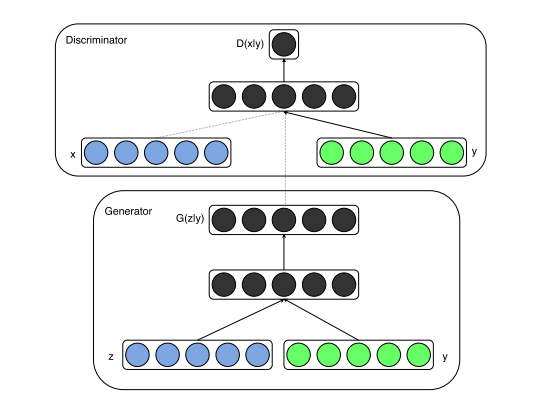

Dans l'idée le but, c'est d'ajouter une condition en entrée du générateur et du discriminateur. en l'occurence pour nous, cette condition c'est les labels de mnist.  
Ce qui nous donne, en entrée du générateur un vecteur samplé d'une gaussienne, concaténé à un label encodé (en one hot encode, d'après l'article).  
Et pareil pour le discriminateur, à la différence que celui prend en entrée une image, donc ça va changer la tête du vecteur d'encodage du label.  
MAIS dans l'idée ça revient au même.

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os
from helper_plot import hdr_plot_style
hdr_plot_style(font_size=12)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
batch_size = 32

# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [5]:
# Adding batchnorm is better to stabilize the training in both generator and discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels + num_classes
        self.label_embedding = nn.Embedding(num_classes, 28*28*10) # Permet d'encoder les labels pour pouvoir les concaténer avec l'entrée du discriminateur... donc 10 classes dans 10*28*28 dimensions (correspond à une image...)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2), # LeakyRelu pour le discriminateur
            nn.Dropout(0.3), # Pas de batchnorm en entrée de discriminator, cause d'instabilité de training
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
                   
            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            nn.Sigmoid()            
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 1, 28, 28)
        c = self.label_embedding(labels)
        c = c.view(x.size(0), 10, 28, 28)
        x = torch.cat([x, c], dim=1)
        output = self.model(x)
        return output

In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (label_embedding): Embedding(10, 7840)
  (model): Sequential(
    (0): Conv2d(11, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.3, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim + num_classes
        self.label_embedding = nn.Embedding(num_classes, 10) # Correspond à une autre représentation du one_hot_encode: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
                                                             # Permet d'encoder les labels de mnist dans un tenseur de 10 valeurs (matrice de 10x10 pour 10 classes => 0 = [0000000000])
                                                             # => 0 = [1000000000])
                                                             # => 1 = [0100000000])
                                                             # ....
        self.fc = nn.Sequential(
          nn.Linear(input_dim, 7*7*256, bias=False),
          nn.BatchNorm1d(7*7*256),
          nn.ReLU()
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128), # Les ajouts de batchnorm permettent de stabiliser le training
            nn.ReLU(), # simple ReLu pour le generateur
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False), # Pas de batchnorm en sortie de generator, cause d'instabilité sinon
            nn.Tanh() # Tanh utile car les images du dataset sont normalisées entre [-1 ; 1].
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.fc(x)
        output = output.view(-1, 256, 7, 7)
        output = self.model(output)
        return output

In [8]:
generator = Generator().to(device)
print(generator)

Generator(
  (label_embedding): Embedding(10, 10)
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [9]:
lr = 1e-4
num_epochs = 100
# loss_function = nn.BCEWithLogitsLoss() # Classic GAN loss
# loss_function = nn.BCEWithLogitsLoss() # Classic GAN loss if use of sigmoid at the output of discriminator
loss_function = nn.MSELoss() # LSGAN loss
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

In [11]:
def train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path):

  if os.path.isfile(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    discriminator.load_state_dict(ckpt['discriminator'])
    generator.load_state_dict(ckpt['generator'])

    optimizer_discriminator.load_state_dict(ckpt['optimizer_disc'])
    optimizer_generator.load_state_dict(ckpt['optimizer_gen'])

    start_epoch = ckpt['epoch']
  
  else:
    start_epoch = 0


  for epoch in range(start_epoch, start_epoch + num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise, mnist_labels)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples, mnist_labels)
          disc_fake_output = discriminator(fake_samples.detach(), mnist_labels) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          disc_fake_output = discriminator(fake_samples, mnist_labels)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              writer.add_scalar("Loss/Discriminator_train", loss_discriminator, epoch)
              writer.add_scalar("Loss/Generator_train", loss_generator, epoch)
              writer.flush()
              
              latent_space_samples = torch.randn(batch_size, 100).to(device)
              generated_samples = generator(latent_space_samples, mnist_labels)
              generated_samples = generated_samples.cpu().detach()

              figure = plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  img = plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.title('label: ' + str(mnist_labels[i].cpu().detach().numpy()))
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()
              
              writer.add_figure('4_mnist_images', figure, epoch)
              writer.flush()

              # Save checkpoint if the model (to prevent training problem)
              checkpoint = {
                  'epoch': epoch + 1,
                  'generator': generator.state_dict(),
                  'discriminator': discriminator.state_dict(),
                  'optimizer_gen': optimizer_generator.state_dict(),
                  'optimizer_disc': optimizer_discriminator.state_dict()
              }
              torch.save(checkpoint, checkpoint_path)

In [ ]:
ckpt_path = 'mnist_conditional_lsgan_BNgd_200epo.pt'
writer = SummaryWriter('runs/' + ckpt_path)

Epoch: 100 Loss D.: 0.24249298870563507
Epoch: 100 Loss G.: 0.27120712399482727


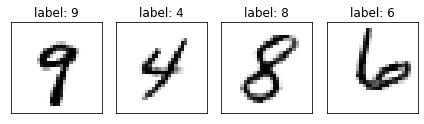

Epoch: 101 Loss D.: 0.2687641680240631
Epoch: 101 Loss G.: 0.2519739270210266


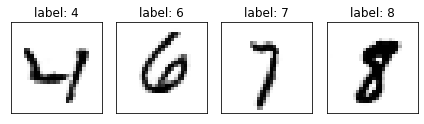

Epoch: 102 Loss D.: 0.24474020302295685
Epoch: 102 Loss G.: 0.21983376145362854


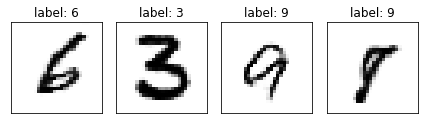

Epoch: 103 Loss D.: 0.1878322958946228
Epoch: 103 Loss G.: 0.33628955483436584


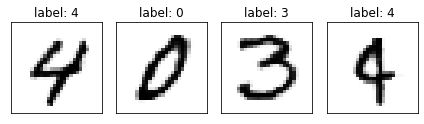

Epoch: 104 Loss D.: 0.24130915105342865
Epoch: 104 Loss G.: 0.2189164161682129


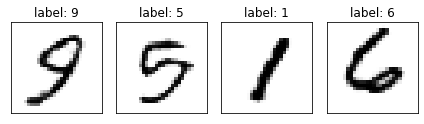

Epoch: 105 Loss D.: 0.23532477021217346
Epoch: 105 Loss G.: 0.2944386899471283


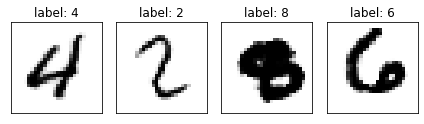

Epoch: 106 Loss D.: 0.26029127836227417
Epoch: 106 Loss G.: 0.25439614057540894


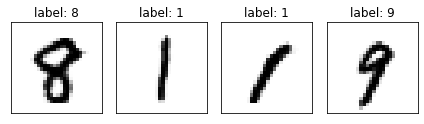

Epoch: 107 Loss D.: 0.22991162538528442
Epoch: 107 Loss G.: 0.2809164524078369


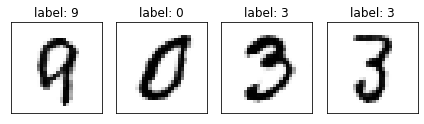

Epoch: 108 Loss D.: 0.1793525367975235
Epoch: 108 Loss G.: 0.25523829460144043


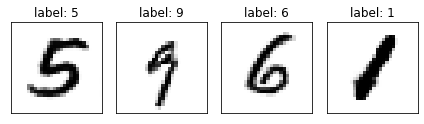

Epoch: 109 Loss D.: 0.2511705756187439
Epoch: 109 Loss G.: 0.2856151759624481


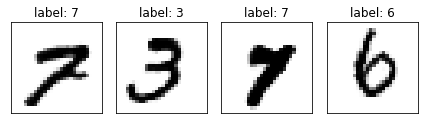

Epoch: 110 Loss D.: 0.2615765929222107
Epoch: 110 Loss G.: 0.3455342948436737


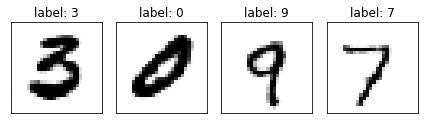

Epoch: 111 Loss D.: 0.2359810769557953
Epoch: 111 Loss G.: 0.27925992012023926


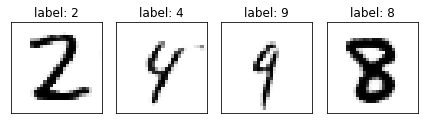

Epoch: 112 Loss D.: 0.22676774859428406
Epoch: 112 Loss G.: 0.27910593152046204


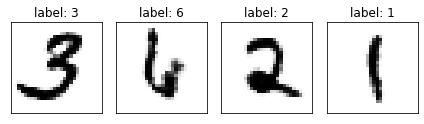

Epoch: 113 Loss D.: 0.22782482206821442
Epoch: 113 Loss G.: 0.32267946004867554


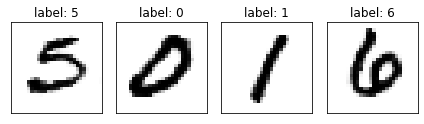

Epoch: 114 Loss D.: 0.20947833359241486
Epoch: 114 Loss G.: 0.2975861728191376


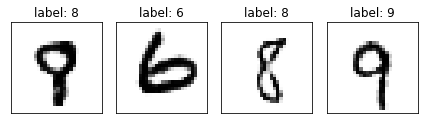

Epoch: 115 Loss D.: 0.21063941717147827
Epoch: 115 Loss G.: 0.38408344984054565


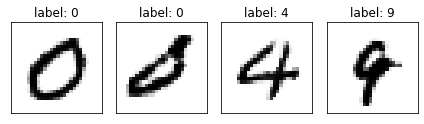

Epoch: 116 Loss D.: 0.26783668994903564
Epoch: 116 Loss G.: 0.2990954518318176


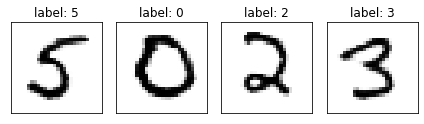

Epoch: 117 Loss D.: 0.26035380363464355
Epoch: 117 Loss G.: 0.24891728162765503


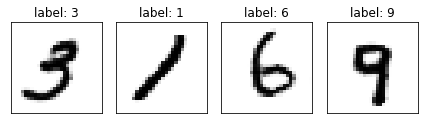

Epoch: 118 Loss D.: 0.2594090402126312
Epoch: 118 Loss G.: 0.27705812454223633


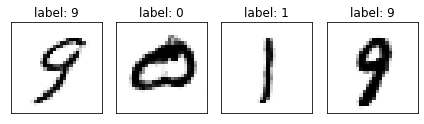

Epoch: 119 Loss D.: 0.2354786992073059
Epoch: 119 Loss G.: 0.20048928260803223


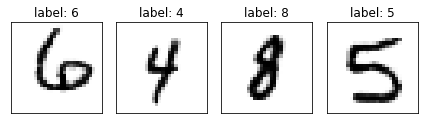

Epoch: 120 Loss D.: 0.24414195120334625
Epoch: 120 Loss G.: 0.3148631453514099


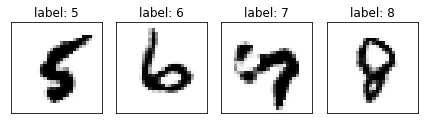

Epoch: 121 Loss D.: 0.22864560782909393
Epoch: 121 Loss G.: 0.24197795987129211


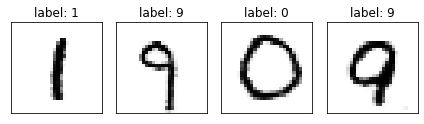

Epoch: 122 Loss D.: 0.26943716406822205
Epoch: 122 Loss G.: 0.27433669567108154


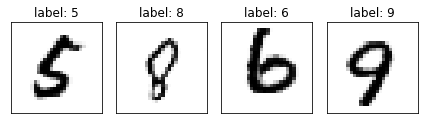

Epoch: 123 Loss D.: 0.28754687309265137
Epoch: 123 Loss G.: 0.28219252824783325


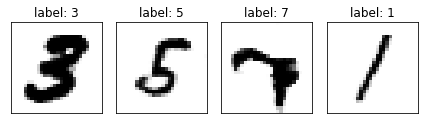

Epoch: 124 Loss D.: 0.2620067596435547
Epoch: 124 Loss G.: 0.2470354437828064


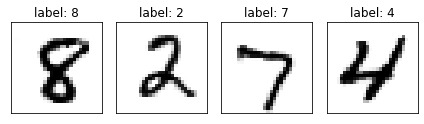

Epoch: 125 Loss D.: 0.24053315818309784
Epoch: 125 Loss G.: 0.29610100388526917


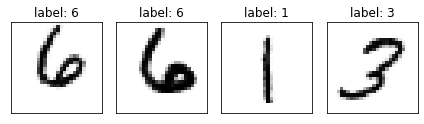

Epoch: 126 Loss D.: 0.19176703691482544
Epoch: 126 Loss G.: 0.35032957792282104


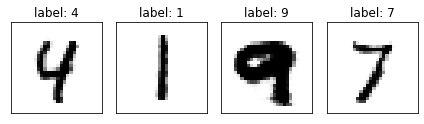

Epoch: 127 Loss D.: 0.22938330471515656
Epoch: 127 Loss G.: 0.20337337255477905


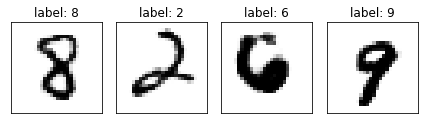

Epoch: 128 Loss D.: 0.20513276755809784
Epoch: 128 Loss G.: 0.3715978264808655


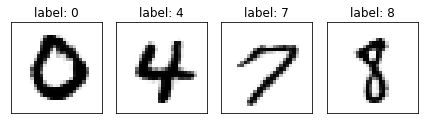

Epoch: 129 Loss D.: 0.25433608889579773
Epoch: 129 Loss G.: 0.22582897543907166


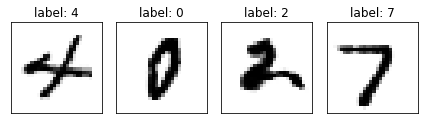

Epoch: 130 Loss D.: 0.24464601278305054
Epoch: 130 Loss G.: 0.2705235779285431


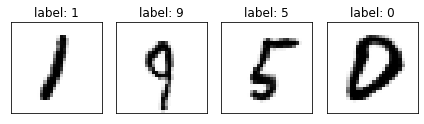

Epoch: 131 Loss D.: 0.23972177505493164
Epoch: 131 Loss G.: 0.3334049582481384


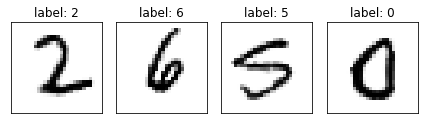

Epoch: 132 Loss D.: 0.19160614907741547
Epoch: 132 Loss G.: 0.33252573013305664


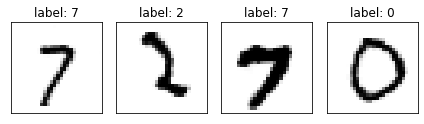

Epoch: 133 Loss D.: 0.19805148243904114
Epoch: 133 Loss G.: 0.37137940526008606


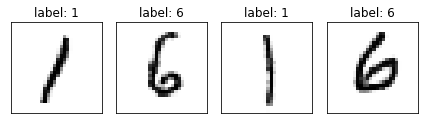

Epoch: 134 Loss D.: 0.19217830896377563
Epoch: 134 Loss G.: 0.26184511184692383


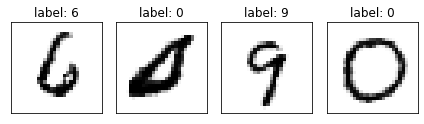

Epoch: 135 Loss D.: 0.17599469423294067
Epoch: 135 Loss G.: 0.3639720678329468


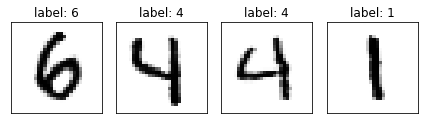

Epoch: 136 Loss D.: 0.21249347925186157
Epoch: 136 Loss G.: 0.32587021589279175


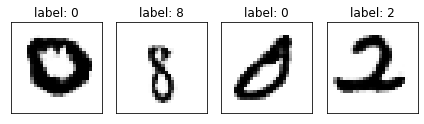

Epoch: 137 Loss D.: 0.22928458452224731
Epoch: 137 Loss G.: 0.3198568522930145


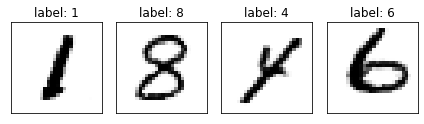

Epoch: 138 Loss D.: 0.23795971274375916
Epoch: 138 Loss G.: 0.3894197940826416


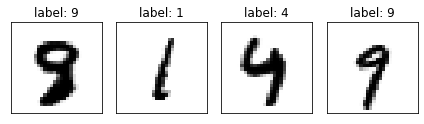

Epoch: 139 Loss D.: 0.27856895327568054
Epoch: 139 Loss G.: 0.3543986678123474


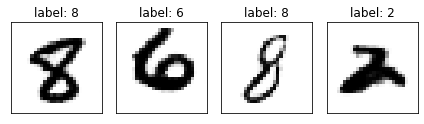

Epoch: 140 Loss D.: 0.13037948310375214
Epoch: 140 Loss G.: 0.33766281604766846


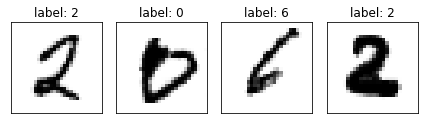

Epoch: 141 Loss D.: 0.3069695830345154
Epoch: 141 Loss G.: 0.36667490005493164


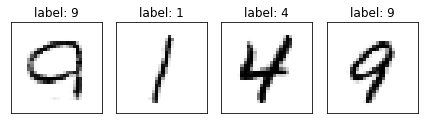

Epoch: 142 Loss D.: 0.1920625865459442
Epoch: 142 Loss G.: 0.4201076030731201


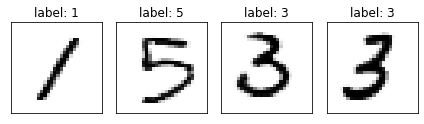

Epoch: 143 Loss D.: 0.21922287344932556
Epoch: 143 Loss G.: 0.33940500020980835


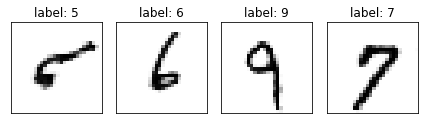

Epoch: 144 Loss D.: 0.23707234859466553
Epoch: 144 Loss G.: 0.27730289101600647


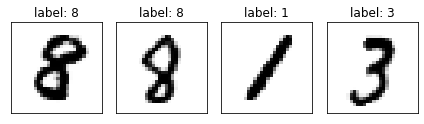

Epoch: 145 Loss D.: 0.24647238850593567
Epoch: 145 Loss G.: 0.41104352474212646


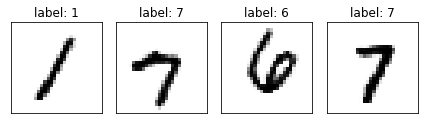

Epoch: 146 Loss D.: 0.22983895242214203
Epoch: 146 Loss G.: 0.3867226243019104


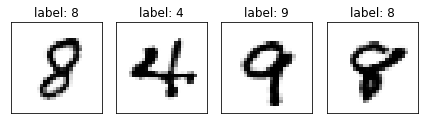

Epoch: 147 Loss D.: 0.22276552021503448
Epoch: 147 Loss G.: 0.25183218717575073


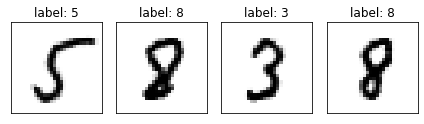

Epoch: 148 Loss D.: 0.2086714208126068
Epoch: 148 Loss G.: 0.4259182810783386


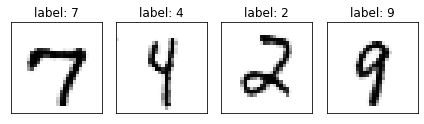

Epoch: 149 Loss D.: 0.18578648567199707
Epoch: 149 Loss G.: 0.28640860319137573


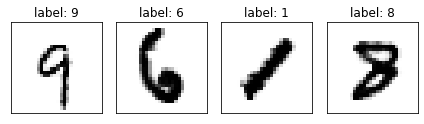

Epoch: 150 Loss D.: 0.19425740838050842
Epoch: 150 Loss G.: 0.29916077852249146


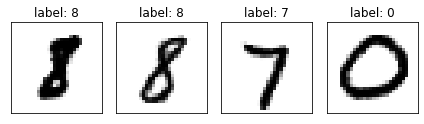

Epoch: 151 Loss D.: 0.20267412066459656
Epoch: 151 Loss G.: 0.3637266755104065


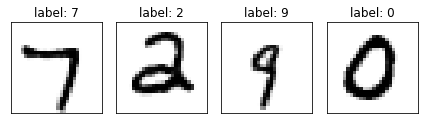

Epoch: 152 Loss D.: 0.19097116589546204
Epoch: 152 Loss G.: 0.42543452978134155


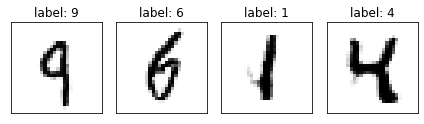

Epoch: 153 Loss D.: 0.21444356441497803
Epoch: 153 Loss G.: 0.4291737675666809


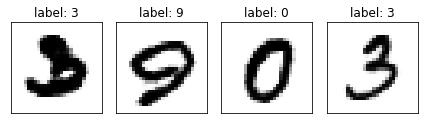

Epoch: 154 Loss D.: 0.24403062462806702
Epoch: 154 Loss G.: 0.26231053471565247


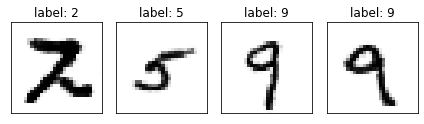

Epoch: 155 Loss D.: 0.1758643537759781
Epoch: 155 Loss G.: 0.45513224601745605


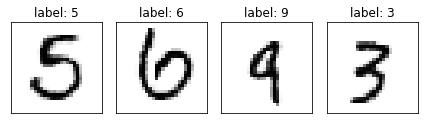

Epoch: 156 Loss D.: 0.26798558235168457
Epoch: 156 Loss G.: 0.39582228660583496


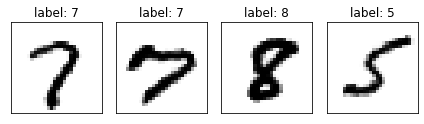

Epoch: 157 Loss D.: 0.2072146236896515
Epoch: 157 Loss G.: 0.39837807416915894


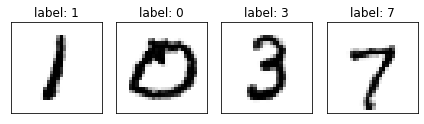

Epoch: 158 Loss D.: 0.30370473861694336
Epoch: 158 Loss G.: 0.44181764125823975


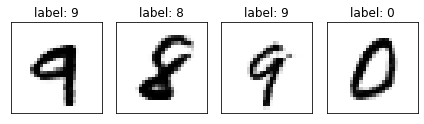

Epoch: 159 Loss D.: 0.19862100481987
Epoch: 159 Loss G.: 0.3245745897293091


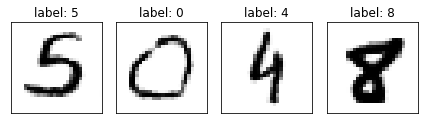

Epoch: 160 Loss D.: 0.22578459978103638
Epoch: 160 Loss G.: 0.392605185508728


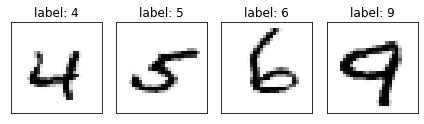

Epoch: 161 Loss D.: 0.16952241957187653
Epoch: 161 Loss G.: 0.45869311690330505


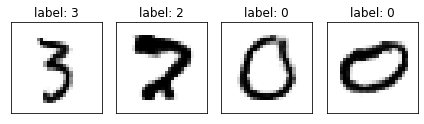

Epoch: 162 Loss D.: 0.2555714547634125
Epoch: 162 Loss G.: 0.3238052427768707


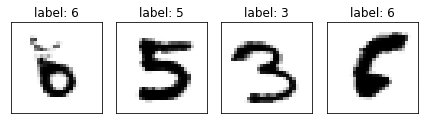

Epoch: 163 Loss D.: 0.24844512343406677
Epoch: 163 Loss G.: 0.24138903617858887


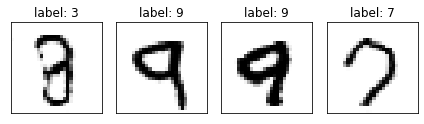

Epoch: 164 Loss D.: 0.16055020689964294
Epoch: 164 Loss G.: 0.3511815667152405


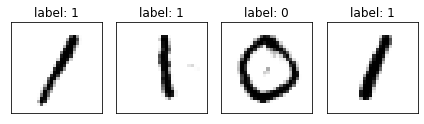

Epoch: 165 Loss D.: 0.24385756254196167
Epoch: 165 Loss G.: 0.39231371879577637


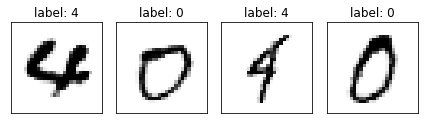

Epoch: 166 Loss D.: 0.18114976584911346
Epoch: 166 Loss G.: 0.43599677085876465


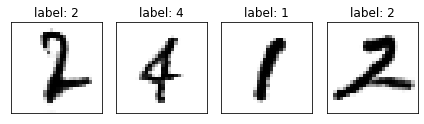

Epoch: 167 Loss D.: 0.22545373439788818
Epoch: 167 Loss G.: 0.21286195516586304


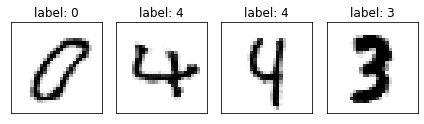

Epoch: 168 Loss D.: 0.17863428592681885
Epoch: 168 Loss G.: 0.3896239399909973


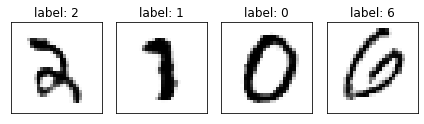

Epoch: 169 Loss D.: 0.18825697898864746
Epoch: 169 Loss G.: 0.30146554112434387


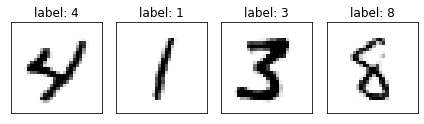

Epoch: 170 Loss D.: 0.18706300854682922
Epoch: 170 Loss G.: 0.279346227645874


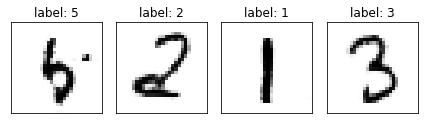

Epoch: 171 Loss D.: 0.2155662178993225
Epoch: 171 Loss G.: 0.3176718056201935


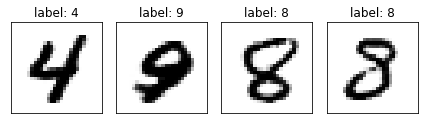

Epoch: 172 Loss D.: 0.23929506540298462
Epoch: 172 Loss G.: 0.3931966722011566


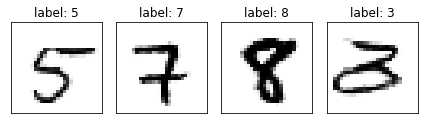

Epoch: 173 Loss D.: 0.18456582725048065
Epoch: 173 Loss G.: 0.46070626378059387


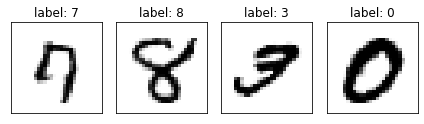

Epoch: 174 Loss D.: 0.1640361249446869
Epoch: 174 Loss G.: 0.4159291982650757


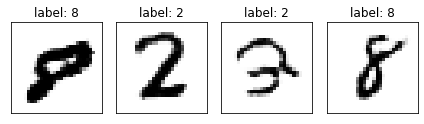

Epoch: 175 Loss D.: 0.22492757439613342
Epoch: 175 Loss G.: 0.35226061940193176


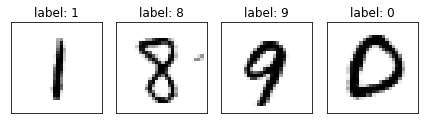

Epoch: 176 Loss D.: 0.16271263360977173
Epoch: 176 Loss G.: 0.5703709125518799


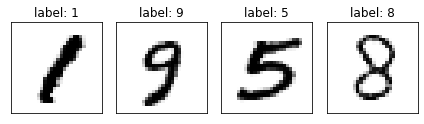

Epoch: 177 Loss D.: 0.11504510045051575
Epoch: 177 Loss G.: 0.333454430103302


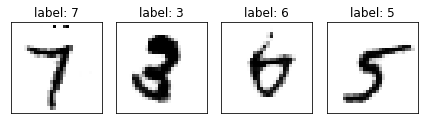

Epoch: 178 Loss D.: 0.21784700453281403
Epoch: 178 Loss G.: 0.22316370904445648


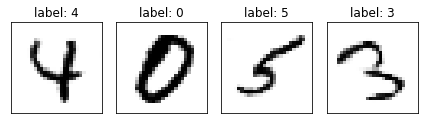

Epoch: 179 Loss D.: 0.21955329179763794
Epoch: 179 Loss G.: 0.3185080885887146


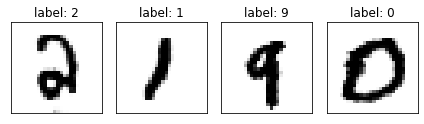

Epoch: 180 Loss D.: 0.19699546694755554
Epoch: 180 Loss G.: 0.4278869032859802


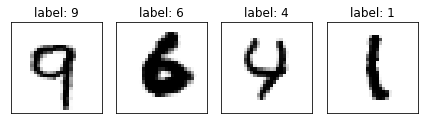

Epoch: 181 Loss D.: 0.21674509346485138
Epoch: 181 Loss G.: 0.3774475157260895


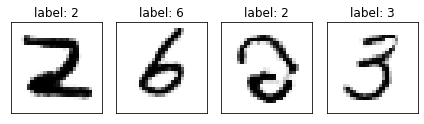

Epoch: 182 Loss D.: 0.15276791155338287
Epoch: 182 Loss G.: 0.4764675796031952


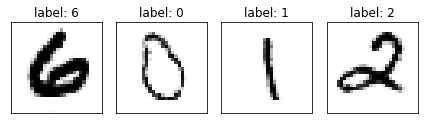

Epoch: 183 Loss D.: 0.2083265781402588
Epoch: 183 Loss G.: 0.4044790267944336


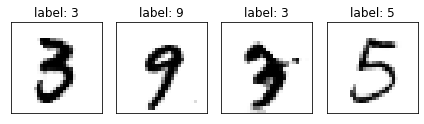

Epoch: 184 Loss D.: 0.25159183144569397
Epoch: 184 Loss G.: 0.15633325278759003


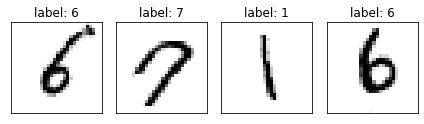

Epoch: 185 Loss D.: 0.215600848197937
Epoch: 185 Loss G.: 0.3615725040435791


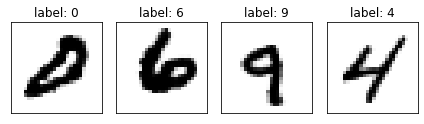

Epoch: 186 Loss D.: 0.13141193985939026
Epoch: 186 Loss G.: 0.4118971526622772


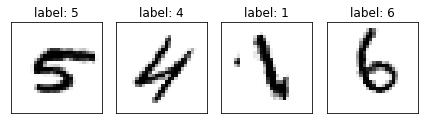

Epoch: 187 Loss D.: 0.22001956403255463
Epoch: 187 Loss G.: 0.4059741199016571


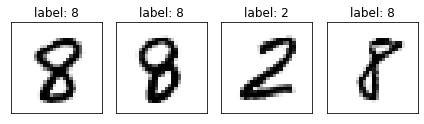

Epoch: 188 Loss D.: 0.1790512353181839
Epoch: 188 Loss G.: 0.43632158637046814


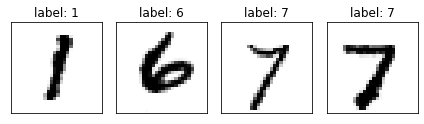

Epoch: 189 Loss D.: 0.2047303318977356
Epoch: 189 Loss G.: 0.16242413222789764


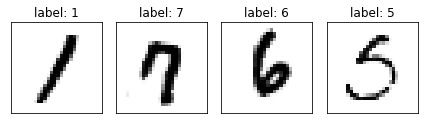

Epoch: 190 Loss D.: 0.25281310081481934
Epoch: 190 Loss G.: 0.36247169971466064


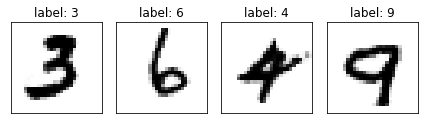

Epoch: 191 Loss D.: 0.31634944677352905
Epoch: 191 Loss G.: 0.29529625177383423


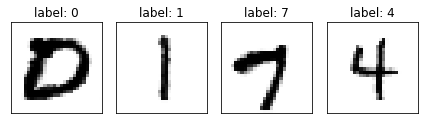

Epoch: 192 Loss D.: 0.2573164999485016
Epoch: 192 Loss G.: 0.2512086033821106


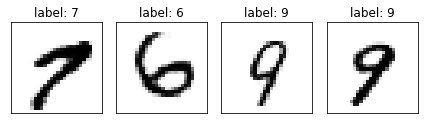

Epoch: 193 Loss D.: 0.13397635519504547
Epoch: 193 Loss G.: 0.41451871395111084


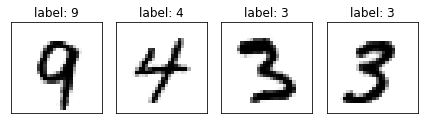

Epoch: 194 Loss D.: 0.26142317056655884
Epoch: 194 Loss G.: 0.3879547715187073


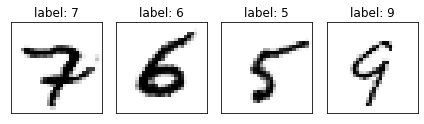

Epoch: 195 Loss D.: 0.1208527535200119
Epoch: 195 Loss G.: 0.471066951751709


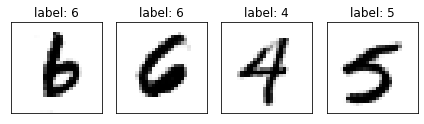

Epoch: 196 Loss D.: 0.2966125011444092
Epoch: 196 Loss G.: 0.3790530562400818


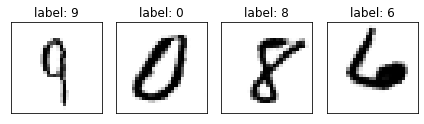

Epoch: 197 Loss D.: 0.25021791458129883
Epoch: 197 Loss G.: 0.2800418734550476


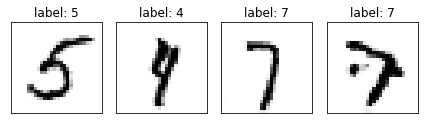

Epoch: 198 Loss D.: 0.276569128036499
Epoch: 198 Loss G.: 0.16849355399608612


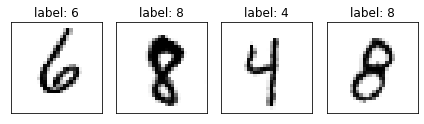

Epoch: 199 Loss D.: 0.1656629592180252
Epoch: 199 Loss G.: 0.4482501447200775


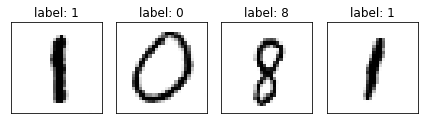

In [ ]:
# Lance la boucle de training, si un checkpoint est trouvé, alors continue le training, sinon en démarre un nouveau
train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path='../trained_model/'+ckpt_path)

### Test du CGAN

In [37]:
ckpt_path = '../trained_model/mnist_conditional_lsgan_BNgd_200epo.pt'

In [38]:
if os.path.isfile(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
    discriminator.load_state_dict(ckpt['discriminator'])
    generator.load_state_dict(ckpt['generator'])

In [39]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
labels = torch.randint(0, 10, size=(batch_size,))

generated_samples = generator(latent_space_samples, labels)
generated_samples = generated_samples.cpu().detach()

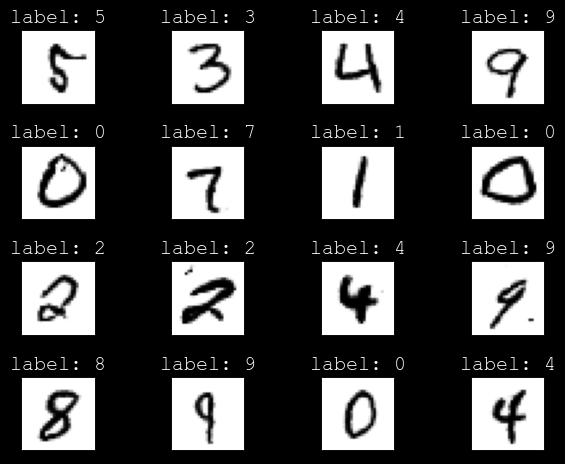

In [40]:
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.title('label: ' + str(labels[i].numpy()))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()